# HPO Config Analysis

This notebook inspects Optuna-sampled configurations stored under `/data2/brain2text/hpo/hpo_configs/baseline_hpo_b2t25` to help refine the hyperparameter search space.


In [2]:
import json
import math
import os
from pathlib import Path

import pandas as pd
import seaborn as sns
import yaml
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

STUDY_ROOTS = {
    "b2t25": Path("/data2/brain2text/hpo/hpo_configs/baseline_hpo_b2t25"),
    "combined": Path("/data2/brain2text/hpo/hpo_configs/baseline_hpo_combined"),
}

study_config_paths = {
    study: sorted(root.glob("trial*_config.yaml"))
    for study, root in STUDY_ROOTS.items()
}
pd.Series({study: len(paths) for study, paths in study_config_paths.items()}, name="num_configs")


b2t25       50
combined    50
Name: num_configs, dtype: int64

In [3]:
def extract_config_fields(study: str, config_path: Path) -> dict:
    with config_path.open() as fh:
        cfg = yaml.safe_load(fh)
    model_cfg = cfg["model"][cfg["modelType"]]
    chunk_cfg = model_cfg.get("chunked_attention", {})

    trial_number = int(config_path.stem.split("_")[1])

    return {
        # file and directories
        "study": study,
        "trial_number": trial_number,
        "trial_id": f"{study}_trial_{trial_number}",
        "config_path": str(config_path),
        # tuned parameter
        "learning_rate": cfg["learning_rate"],
        "l2_decay": cfg["l2_decay"],
        "dropout": cfg["dropout"],
        "num_masks": cfg["num_masks"],
        "max_mask_pct": cfg["max_mask_pct"],
        "n_heads": model_cfg.get("n_heads"),
        "dim_head": model_cfg.get("dim_head"),
        "depth": model_cfg.get("depth"),
        "d_model": model_cfg.get("n_heads", 0) * model_cfg.get("dim_head", 0),
        "chunk_size_min": chunk_cfg.get("chunk_size_min"),
        "chunk_size_max": chunk_cfg.get("chunk_size_max"),
        "context_sec_min": chunk_cfg.get("context_sec_min"),
        "context_sec_max": chunk_cfg.get("context_sec_max"),
        "left_constrain_prob": chunk_cfg.get("left_constrain_prob"),
        "chunkwise_prob": chunk_cfg.get("chunkwise_prob"),
        "eval_chunk_size": chunk_cfg.get("eval", {}).get("chunk_size"),
        "eval_context_chunks": chunk_cfg.get("eval", {}).get("context_chunks"),
        # seed
        "seed": cfg["seed"],
    }

records = []
for study, paths in study_config_paths.items():
    records.extend(extract_config_fields(study, path) for path in paths)

config_df = pd.DataFrame(records).sort_values(["study", "trial_number"]).reset_index(drop=True)
config_df.head()


,study,trial_number,trial_id,config_path,learning_rate,l2_decay,dropout,num_masks,max_mask_pct,n_heads,...,d_model,chunk_size_min,chunk_size_max,context_sec_min,context_sec_max,left_constrain_prob,chunkwise_prob,eval_chunk_size,eval_context_chunks,seed
0,b2t25,0,b2t25_trial_0,/data2/brain2text/hpo/hpo_configs/baseline_hpo...,0.002186,1.042929e-06,0.256617,8,0.150,8,...,440,1,20,3,20,1.0,1.0,4,50,0
1,b2t25,1,b2t25_trial_1,/data2/brain2text/hpo/hpo_configs/baseline_hpo...,0.000500,8.230150e-07,0.100000,14,0.036,6,...,288,1,20,3,20,1.0,1.0,4,50,0
2,b2t25,2,b2t25_trial_2,/data2/brain2text/hpo/hpo_configs/baseline_hpo...,0.001750,1.000000e-05,0.250000,26,0.048,8,...,448,1,20,3,20,1.0,1.0,4,50,0
3,b2t25,3,b2t25_trial_3,/data2/brain2text/hpo/hpo_configs/baseline_hpo...,0.002375,1.000000e-06,0.175000,19,0.046,9,...,468,1,20,3,20,1.0,1.0,4,50,0
4,b2t25,4,b2t25_trial_4,/data2/brain2text/hpo/hpo_configs/baseline_hpo...,0.001125,1.000000e-04,0.325000,21,0.077,7,...,420,1,20,3,20,1.0,1.0,4,50,0


In [3]:
numeric_cols = [
    "learning_rate",
    "l2_decay",
    "dropout",
    "num_masks",
    "max_mask_pct",
    "n_heads",
    "dim_head",
    "depth",
    "d_model",
]
config_df.groupby("study")[numeric_cols].describe().transpose()


study                     b2t25    combined
learning_rate count   50.000000   50.000000
              mean     0.001725    0.001725
              std      0.000733    0.000733
              min      0.000500    0.000500
              25%      0.001096    0.001096
...                         ...         ...
d_model       min    288.000000  288.000000
              25%    379.750000  379.750000
              50%    437.000000  437.000000
              75%    494.500000  494.500000
              max    640.000000  640.000000

[72 rows x 2 columns]

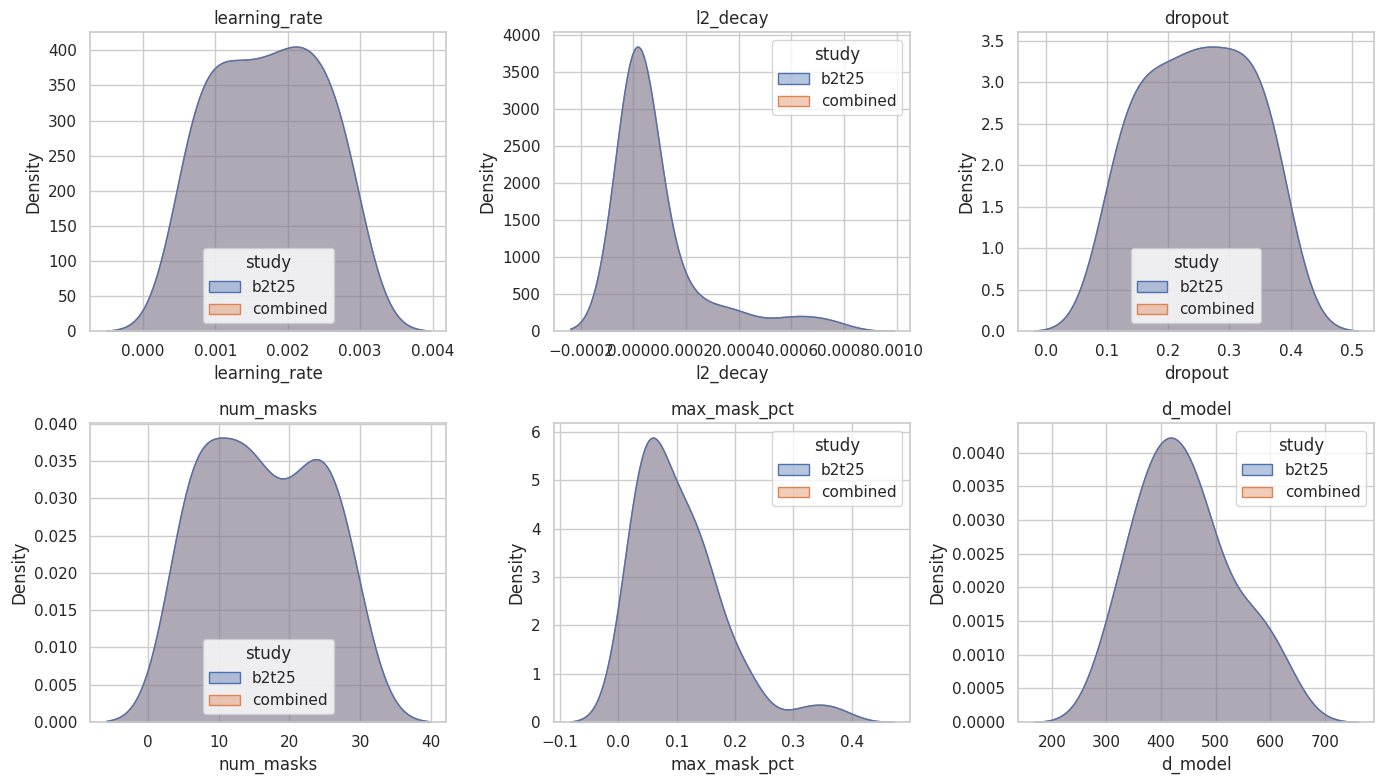

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
cols = ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "d_model"]

for ax, col in zip(axes, cols):
    sns.kdeplot(
        data=config_df,
        x=col,
        hue="study",
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax,
    )
    ax.set_title(col)

plt.tight_layout()


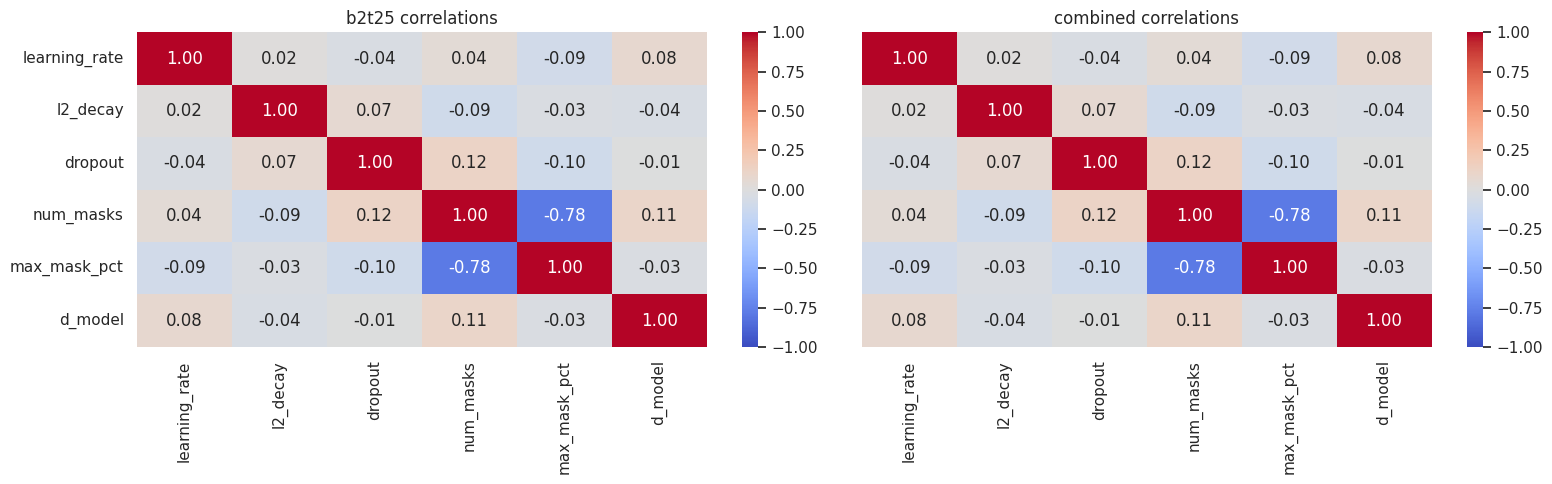

In [5]:
corr_cols = ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "d_model"]
fig, axes = plt.subplots(1, len(STUDY_ROOTS), figsize=(16, 5), sharey=True)

for ax, (study, subset) in zip(axes, config_df.groupby("study")):
    corr = subset[corr_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title(f"{study} correlations")

plt.tight_layout()


In [4]:
best_trials = {
    "b2t25": {
        3: 0.22372,
        19: 0.23261,
        42: 0.19629,
    },
    "combined": {
        30: 0.25283,
        38: 0.29328,
        42: 0.25527,
    },
}

def mark_best(row):
    metric = best_trials.get(row["study"], {}).get(row["trial_number"])
    return pd.Series({"is_best": metric is not None, "best_metric": metric})

tag_df = config_df.apply(mark_best, axis=1)
config_df = pd.concat([config_df, tag_df], axis=1)
config_df.head(50)

combined_worst = config_df.loc[[16, 34, 41, 33, 31, 5],["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "n_heads", "dim_head", "depth"]]
b2t25_worst = config_df.loc[[39, 35, 38, 29, 33, 5],["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "n_heads", "dim_head", "depth"]]
combined_worst = combined_worst.assign(
    mask_intensity=lambda df: df["num_masks"] * df["max_mask_pct"],
    model_dim=lambda df: df["n_heads"] * df["dim_head"] * df["depth"],
)

b2t25_worst = b2t25_worst.assign(
    mask_intensity=lambda df: df["num_masks"] * df["max_mask_pct"],
    model_dim=lambda df: df["n_heads"] * df["dim_head"] * df["depth"],
)

In [7]:
b2t_42 = config_df.loc[[42], ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "n_heads", "dim_head", "depth"]]
b2t_42 = b2t_42.assign(
    mask_intensity=lambda df: df["num_masks"] * df["max_mask_pct"],
    model_dim=lambda df: df["n_heads"] * df["dim_head"] * df["depth"],
)
b2t_42

,learning_rate,l2_decay,dropout,num_masks,max_mask_pct,n_heads,dim_head,depth,mask_intensity,model_dim
42,0.002336,0.000021,0.329688,24,0.035,7,56,5,0.84,1960


In [31]:
combined_worst

,learning_rate,l2_decay,dropout,num_masks,max_mask_pct,n_heads,dim_head,depth,mask_intensity,model_dim
16,0.000656,5.623413e-04,0.268750,8,0.210,9,53,5,1.680,2385
34,0.001867,1.154782e-04,0.160938,7,0.140,9,48,6,0.980,2592
41,0.001086,2.053525e-07,0.179688,5,0.320,9,64,7,1.600,4032
33,0.000617,1.154782e-06,0.310938,24,0.071,6,57,8,1.704,2736
31,0.001828,1.333521e-07,0.221875,16,0.110,8,55,6,1.760,2640
5,0.001437,3.162278e-06,0.287500,5,0.210,7,62,5,1.050,2170


In [32]:
b2t25_worst

,learning_rate,l2_decay,dropout,num_masks,max_mask_pct,n_heads,dim_head,depth,mask_intensity,model_dim
39,0.002180,3.651741e-06,0.198438,17,0.110,8,50,5,1.870,2000
35,0.002492,1.154782e-07,0.385938,11,0.120,10,61,5,1.320,3050
38,0.002805,3.651741e-05,0.273438,29,0.026,9,63,6,0.754,3402
29,0.001203,1.333521e-06,0.146875,6,0.230,9,51,7,1.380,3213
33,0.000617,1.154782e-06,0.310938,24,0.071,6,57,8,1.704,2736
5,0.001437,3.162278e-06,0.287500,5,0.210,7,62,5,1.050,2170


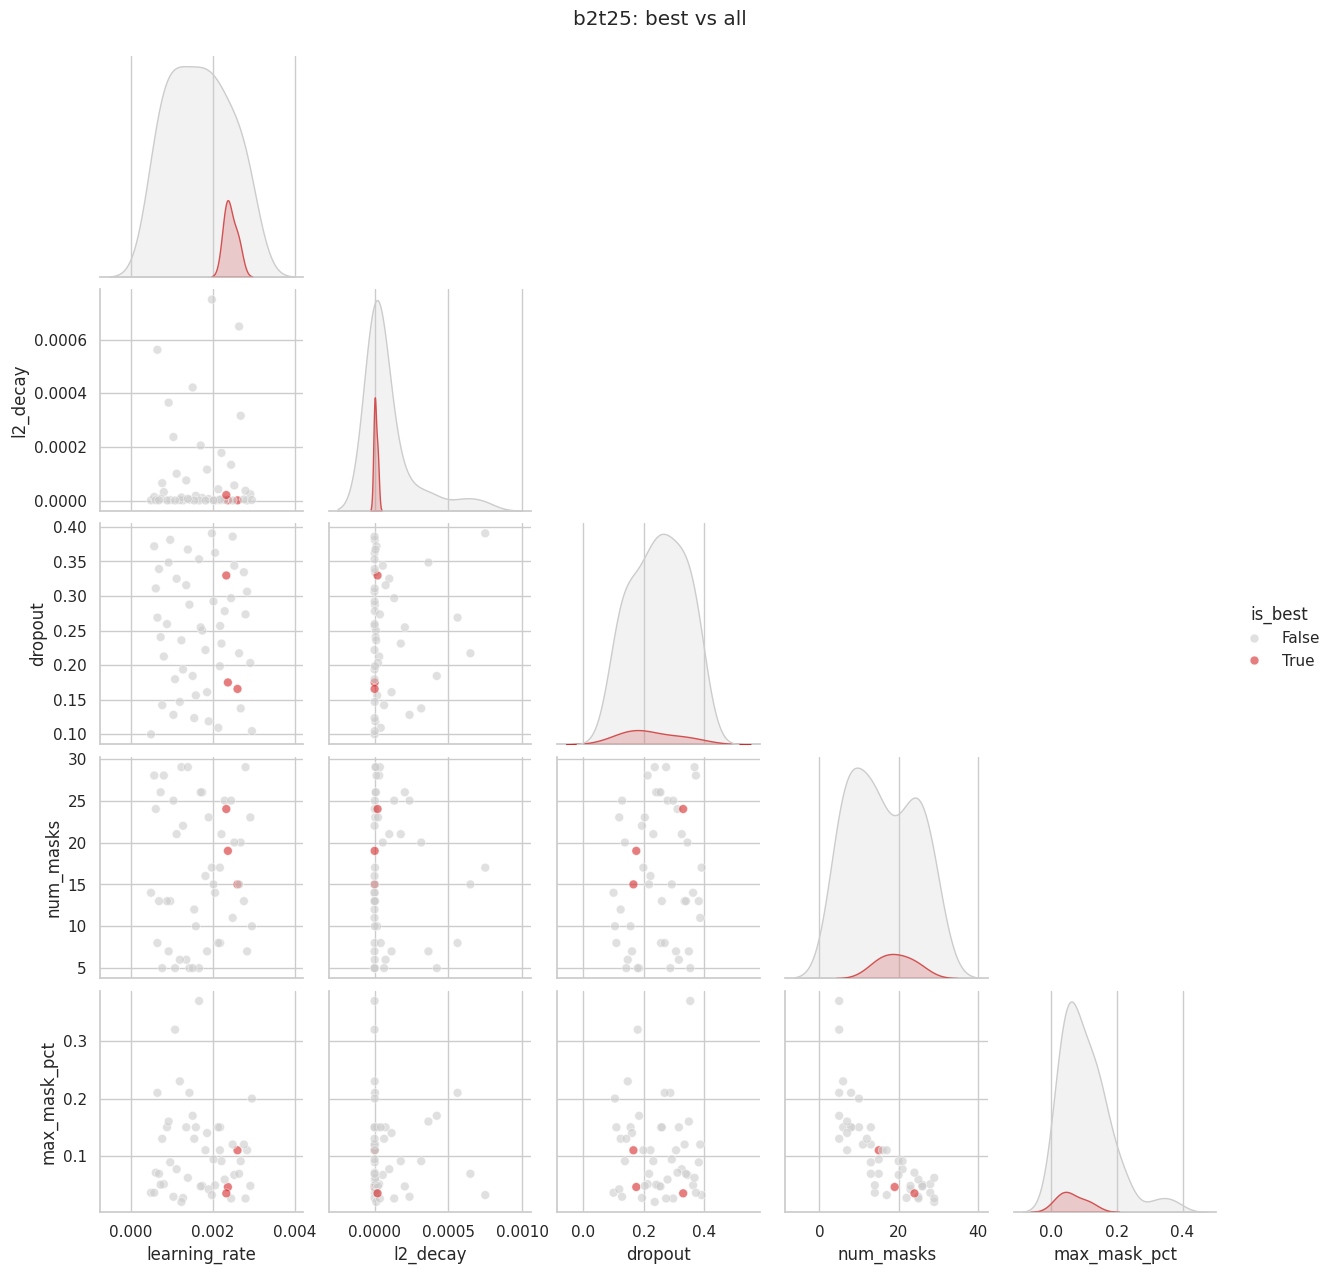

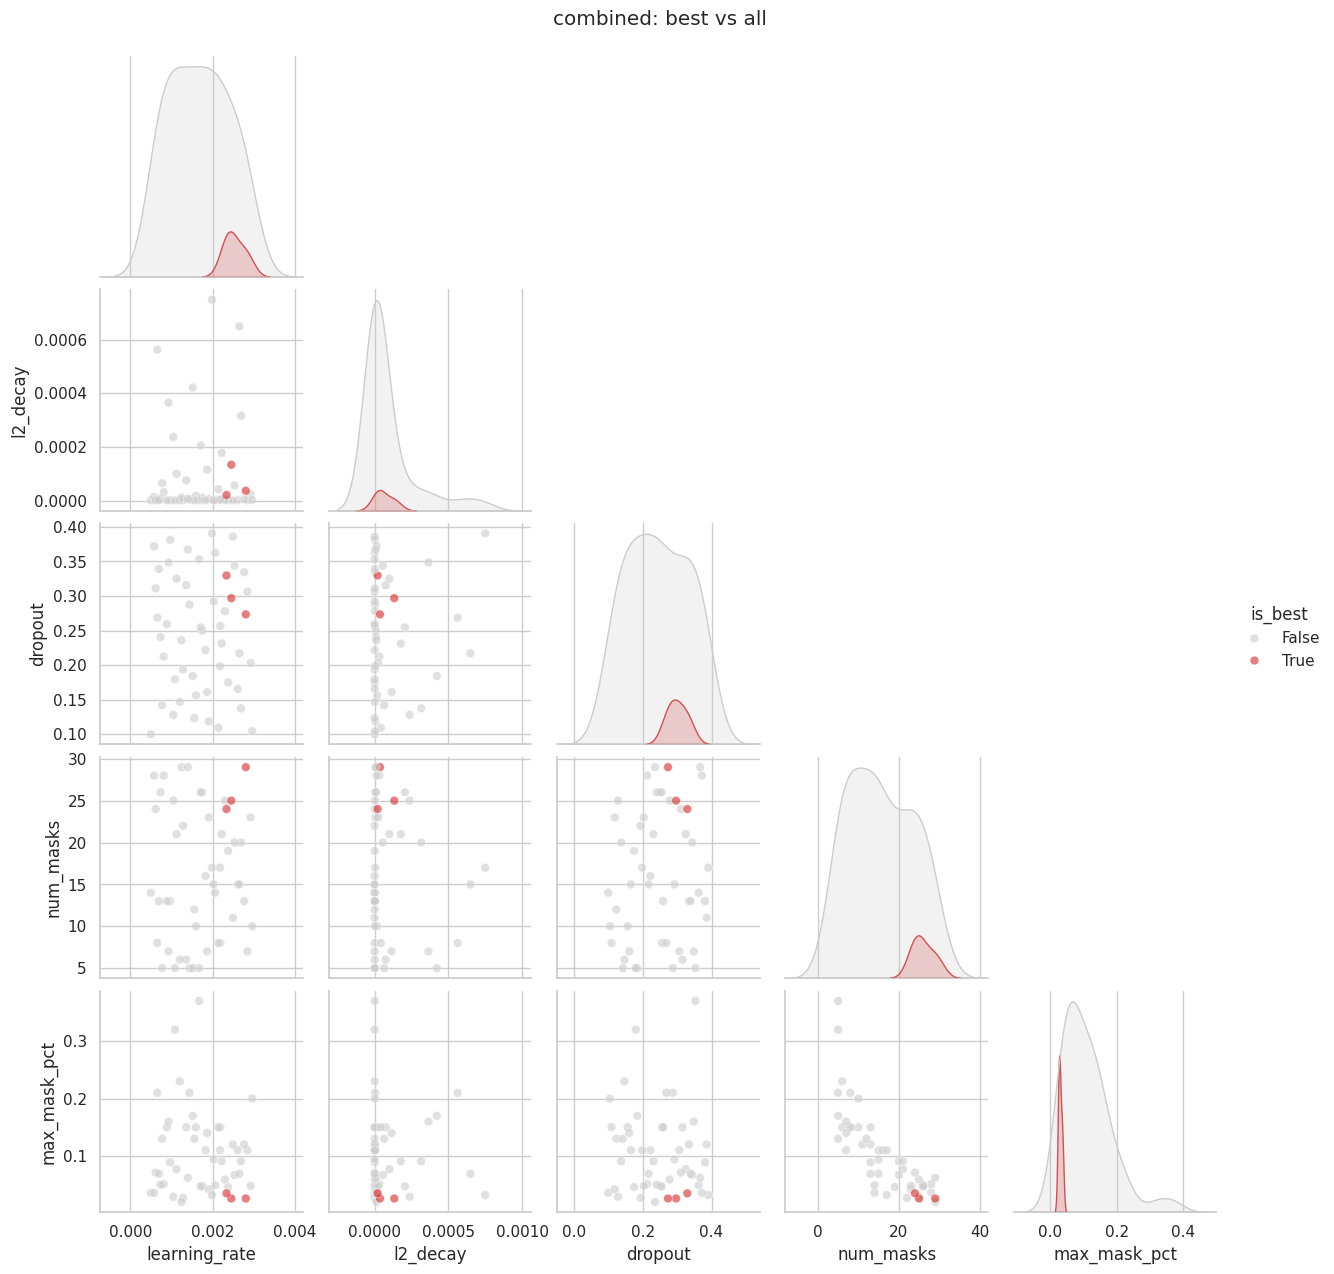

In [7]:
pairplot_vars = ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct"]
palette = {False: "#CCCCCC", True: "#D62728"}

for study, subset in config_df.groupby("study"):
    g = sns.pairplot(
        subset,
        vars=pairplot_vars,
        hue="is_best",
        diag_kind="kde",
        plot_kws={"alpha": 0.6, "s": 40},
        palette=palette,
        corner=True,
    )
    g.fig.suptitle(f"{study}: best vs all", y=1.02)
    plt.show()


In [8]:
summary_cols = ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "d_model"]
quantiles = (
    config_df.groupby("study")[summary_cols]
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    .rename_axis(index={"study": "quantile"})
)
quantiles


learning_rate      l2_decay   dropout  num_masks  max_mask_pct  \
quantile                                                                        
b2t25    0.10       0.000730  3.083187e-07  0.127656       5.90        0.0317   
         0.25       0.001096  8.994732e-07  0.176172       8.50        0.0480   
         0.50       0.001730  6.996379e-06  0.252344      15.00        0.0900   
         0.75       0.002326  7.247661e-05  0.322656      23.75        0.1475   
         0.90       0.002695  3.211224e-04  0.362969      26.20        0.2010   
combined 0.10       0.000730  3.083187e-07  0.127656       5.90        0.0317   
         0.25       0.001096  8.994732e-07  0.176172       8.50        0.0480   
         0.50       0.001730  6.996379e-06  0.252344      15.00        0.0900   
         0.75       0.002326  7.247661e-05  0.322656      23.75        0.1475   
         0.90       0.002695  3.211224e-04  0.362969      26.20        0.2010   

               d_model  
quantile                
b2t25    0.10   340.20  
         0.25   379.75  
         0.50   437.00  
         0.75   494.50  
         0.90   570.60  
combined 0.10   340.20  
         0.25   379.75  
         0.50   437.00  
         0.75   494.50  
         0.90   570.60

In [9]:
def compute_relative_position(values, value):
    min_v = values.min()
    max_v = values.max()
    if math.isclose(max_v, min_v):
        return 0.5
    return (value - min_v) / (max_v - min_v)

best_rows = []
for study, subset in config_df.groupby("study"):
    for trial_number, metric in best_trials.get(study, {}).items():
        row = subset.loc[subset["trial_number"] == trial_number].iloc[0]
        entry = {
            "study": study,
            "trial_number": trial_number,
            "trial_id": row["trial_id"],
            "best_metric": metric,
        }
        for col in summary_cols:
            entry[col] = row[col]
            entry[f"{col}_rel"] = compute_relative_position(subset[col], row[col])
        best_rows.append(entry)

best_positions_df = pd.DataFrame(best_rows)
best_positions_df


,study,trial_number,trial_id,best_metric,learning_rate,learning_rate_rel,l2_decay,l2_decay_rel,dropout,dropout_rel,num_masks,num_masks_rel,max_mask_pct,max_mask_pct_rel,d_model,d_model_rel
0,b2t25,3,b2t25_trial_3,0.22372,0.002375,0.761905,1.000000e-06,0.001180,0.175000,0.258065,19,0.583333,0.046,0.074286,468,0.511364
1,b2t25,19,b2t25_trial_19,0.23261,0.002609,0.857143,7.498942e-07,0.000846,0.165625,0.225806,15,0.416667,0.110,0.257143,504,0.613636
2,b2t25,42,b2t25_trial_42,0.19629,0.002336,0.746032,2.053525e-05,0.027234,0.329688,0.790323,24,0.791667,0.035,0.042857,392,0.295455
3,combined,30,combined_trial_30,0.25283,0.002453,0.793651,1.333521e-04,0.177701,0.296875,0.677419,25,0.833333,0.026,0.017143,420,0.375000
4,combined,38,combined_trial_38,0.29328,0.002805,0.936508,3.651741e-05,0.048550,0.273438,0.596774,29,1.000000,0.026,0.017143,567,0.792614
5,combined,42,combined_trial_42,0.25527,0.002336,0.746032,2.053525e-05,0.027234,0.329688,0.790323,24,0.791667,0.035,0.042857,392,0.295455


In [ ]:
relative_cols = [f"{col}_rel" for col in summary_cols]
rel_melt = best_positions_df.melt(
    id_vars=["study", "trial_number", "trial_id"],
    value_vars=relative_cols,
    var_name="parameter",
    value_name="relative_position",
)
rel_melt["parameter"] = rel_melt["parameter"].str.replace("_rel", "", regex=False)

cat = sns.catplot(
    data=rel_melt,
    x="parameter",
    y="relative_position",
    hue="trial_id",
    col="study",
    kind="bar",
    height=4,
    aspect=1.3,
)
cat.set_titles("{col_name}")
cat.set_axis_labels("parameter", "(value - min) / (max - min)")
for ax in cat.axes.flat:
    ax.axhline(0, color="black", linewidth=0.4)
    ax.axhline(1, color="black", linewidth=0.4)
    ax.set_ylim(-0.05, 1.05)
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")
cat.fig.subplots_adjust(top=0.85)
cat.fig.suptitle("Best-trial position within sampled range")


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

GLOBAL_SEED = 1

viz_cols = ["learning_rate", "l2_decay", "dropout", "num_masks", "max_mask_pct", "n_heads", "dim_head", "depth"]
scaled_df = config_df.dropna(subset=viz_cols).copy()

# Log-transform strictly-positive columns to respect scale
for col in ["learning_rate", "l2_decay", "max_mask_pct"]:
    scaled_df[f"log_{col}"] = np.log10(scaled_df[col])

viz_features = [
    "log_learning_rate",
    "log_l2_decay",
    "dropout",
    "num_masks",
    "log_max_mask_pct",
    "n_heads",
    "dim_head",
    "depth",
]

X = scaled_df[viz_features].values

pca = PCA(n_components=2, random_state=GLOBAL_SEED)
scaled_df[["pca1", "pca2"]] = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=GLOBAL_SEED, perplexity=min(30, len(scaled_df) - 1))
scaled_df[["tsne1", "tsne2"]] = tsne.fit_transform(X)

scaled_df.head()


In [ ]:
def scatter_projection(df, x, y, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue="study",
        style="is_best",
        palette={"b2t25": "#1f77b4", "combined": "#ff7f0e"},
        markers={False: "o", True: "*"},
        s=df["is_best"].map({False: 40, True: 160}),
        alpha=0.8,
    )
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()


scatter_projection(scaled_df, "pca1", "pca2", "PCA projection")
scatter_projection(scaled_df, "tsne1", "tsne2", "t-SNE projection")


In [ ]:
import plotly.express as px

fig = px.parallel_coordinates(
    scaled_df,
    dimensions=viz_features,
    color="best_metric",
    color_continuous_scale="Viridis",
    labels={col: col for col in viz_features},
    title="Parallel coordinates of sampled hyperparameters (color = best metric)"
)
fig.show()
